In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm_notebook
import cv2

In [2]:
train = pd.read_csv('./input/train.csv')
print("train.shape:", train.shape)
train.head(20)

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


# Preprocessing

## 1) Split into ImageId, ClassId

In [3]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]

In [4]:
print('{} = no. of train_images * 4'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

50272 = no. of train_images * 4
train.shape: (50272, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


# No. of defect in an image

In [5]:
train1 = train.groupby(by='ImageId', axis=0).agg({'defect':'sum'})
train1.rename(columns={'defect': 'num_defects'}, inplace=True)
train1['num_defects'] = train1['num_defects'].astype(np.int32)

print('There are {} train_images in total'.format(train1.shape[0]))
print('train1.shape:', train1.shape)
train1.head(10)

There are 12568 train_images in total
train1.shape: (12568, 1)


,num_defects
ImageId,
0002cc93b.jpg,1
00031f466.jpg,0
000418bfc.jpg,0
000789191.jpg,0
0007a71bf.jpg,1
000a4bcdd.jpg,1
000f6bf48.jpg,1
0014fce06.jpg,1
001982b08.jpg,0


# No. of image with 0/1/2/3/4 defects

1    6239
0    5902
2     425
3       2
Name: num_defects, dtype: int64


Text(0, 0.5, 'No. of images')

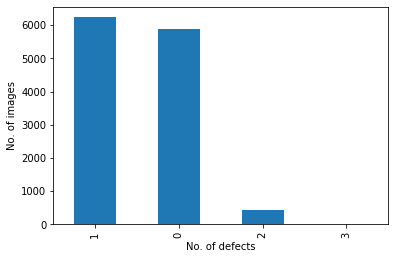

In [6]:
print(train1['num_defects'].value_counts())

train1['num_defects'].value_counts().plot(kind='bar')
plt.xlabel("No. of defects")
plt.ylabel("No. of images")

## 2) Drop rows without defects

In [7]:
train = train[train['defect']==True]

In [8]:
print('There are {} defects in total.'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

There are 7095 defects in total.
train.shape: (7095, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


# No. of images for each Class

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64


Text(0, 0.5, 'No. of images')

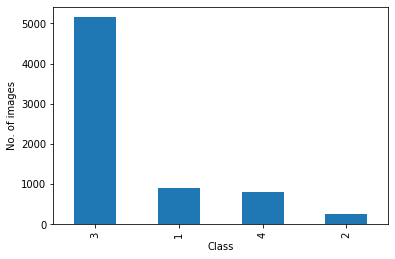

In [9]:
print(train['ClassId'].value_counts())
train['ClassId'].value_counts().plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("No. of images")

# Visualize the masks (Area of the defects)

In [10]:
# Functions for converting between rle (EncodedPixels) & mask (Area of the defects)

def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

def rle2mask(rle, imgshape = (256,1600)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

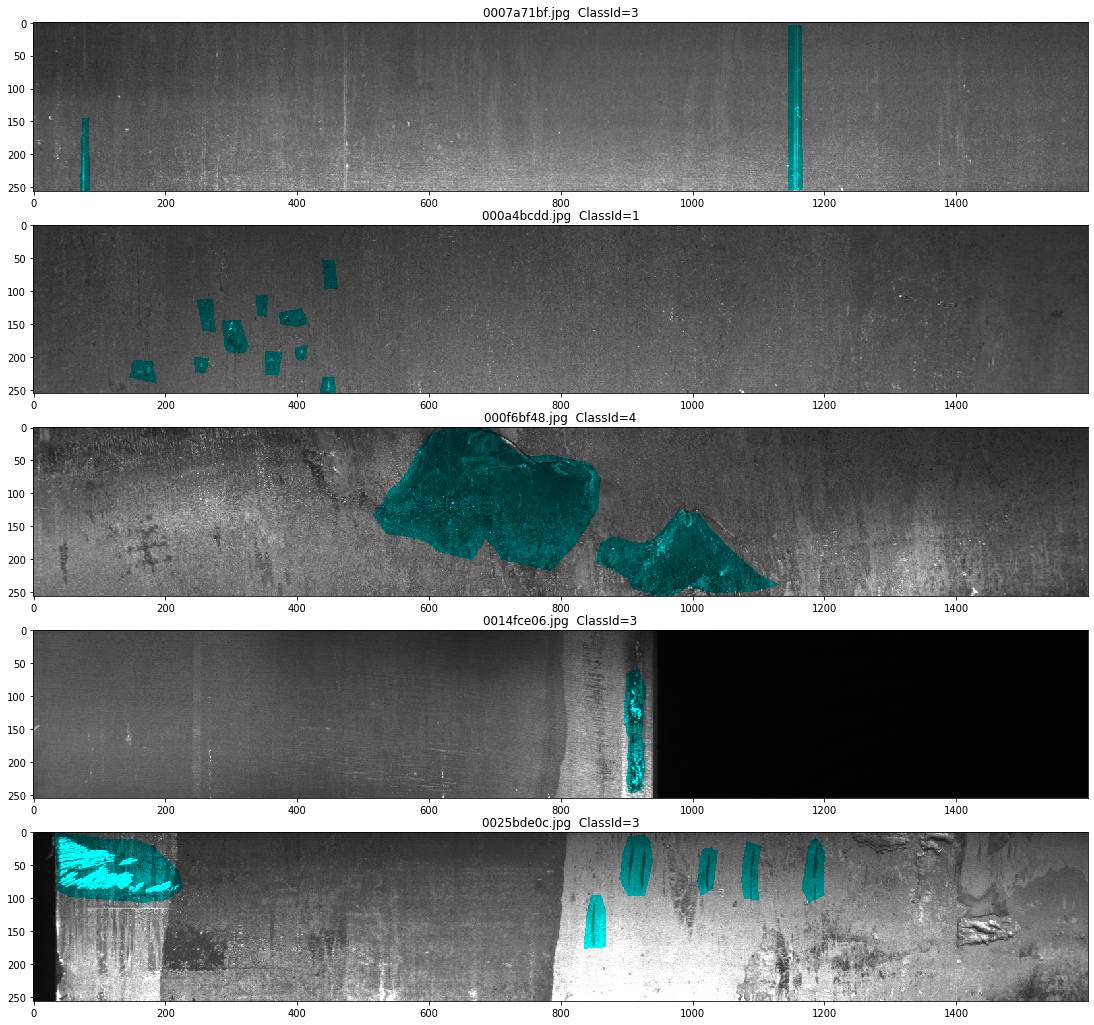

In [11]:
columns = 1
rows = 5

fig = plt.figure(figsize=(20,18))
for i in range(1,columns*rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn+"  ClassId="+c)
    img = cv2.imread( './input/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask_eda(train['EncodedPixels'].iloc[i])    
    img[mask==1,0] = -255   #mask color   #put mask onto img
    plt.imshow(img)
plt.show()

# rle2mask()

In [41]:
index = 5

mask = rle2mask(train['EncodedPixels'].iloc[index], imgshape = (256,1600))
print('mask.shape:', mask.shape)
mask

mask.shape: (256, 1600)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
file_path = './input/train_images/' + str(train['ImageId'].iloc[index])
img = cv2.imread(file_path)
img_rgb = cv2.imread(file_path, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

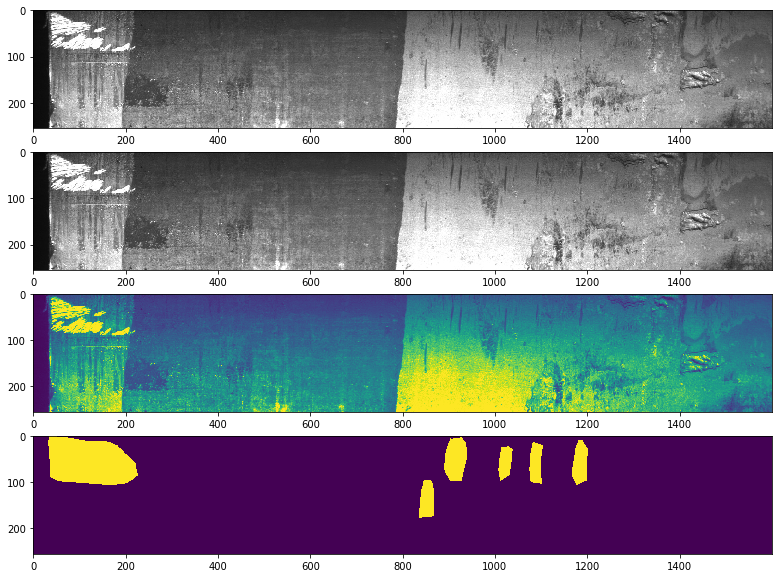

In [47]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,10))
ax0.imshow(img)
ax1.imshow(img_rgb)
ax2.imshow(img_gray)
ax3.imshow(mask)

# mask2rle()

In [68]:
# train['EncodedPixels'].iloc[3]
encodedpixels = mask2rle(mask)
encodedpixels

'131973 1 132228 4 132483 6 132738 8 132993 11 133248 13 133503 16 133757 19 134012 22 134267 24 134522 26 134777 29 135032 31 135287 34 135542 36 135796 40 136050 43 136304 46 136558 50 136812 54 137066 56 137320 59 137574 61 137828 63 138082 65 138336 68 138590 70 138845 71 139101 71 139356 73 139612 73 139868 73 140123 74 140379 74 140634 75 140890 75 141145 77 141400 78 141654 80 141909 81 142164 82 142418 84 142673 85 142928 86 143182 88 143437 89 143692 90 143946 93 144201 94 144456 95 144710 97 144965 98 145220 99 145474 101 145729 103 145983 105 146237 107 146491 109 146745 112 146999 114 147253 116 147506 119 147760 122 148014 124 148268 126 148522 128 148776 131 149030 133 149284 135 149539 136 149793 139 150048 140 150303 141 150557 143 150812 145 151067 146 151321 148 151576 149 151831 151 152086 152 152340 155 152595 156 152850 158 153104 161 153359 163 153614 164 153869 166 154125 167 154380 169 154636 169 154891 171 155147 172 155402 174 155658 174 155913 176 156169 177 

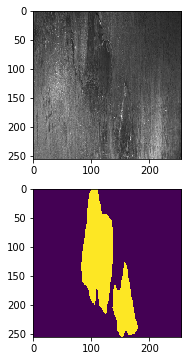

In [69]:
img_size = 256

img = cv2.resize(img, (img_size, img_size))
mask = cv2.resize(mask, (img_size, img_size))

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,6))
ax1.imshow(img)
ax2.imshow(mask)